In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
import os

In [ ]:
!unzip "/content/drive/MyDrive/sign_data.zip" -d "/content/drive/MyDrive/kaggle_sign_data/"

In [ ]:
train_directory = '/content/drive/MyDrive/kaggle_sign_data/sign_data/train'
test_directory = '/content/drive/MyDrive/kaggle_sign_data/sign_data/test'
validation_directory = '/content/drive/MyDrive/kaggle_sign_data/sign_data/validation'


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
    
)


test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size = (224, 224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size=32
)

Found 503 images belonging to 32 classes.
Found 252 images belonging to 21 classes.
Found 384 images belonging to 32 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

vgg_basemodel = VGG16(include_top=True)
resnet_basemodel = ResNet50(include_top=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
vgg_model = tf.keras.Sequential(vgg_basemodel.layers[:-1])
vgg_model.add(tf.keras.layers.Dense(32, activation = 'softmax'))

# Freezing original layers
for layer in vgg_model.layers[:-1]:
    layer.trainable = False

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.001, decay=0.01),
                  metrics=['accuracy'])

history = vgg_model.fit(train_generator,
              epochs=30,
              batch_size=64,
              validation_data=validation_generator,
              callbacks=[early_stopping])

# finetuning with all layers set trainable

for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9, lr=0.0001),
                  metrics=['accuracy'])

history2 = vgg_model.fit(train_generator,
              epochs=5,
              batch_size=64,
              validation_data=validation_generator,
              callbacks=[early_stopping])

vgg_model.save('/content/drive/MyDrive/kaggle_sign_data/saved_models1/vgg_finetuned_model')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
28/28 [==============================] - 384s 14s/step - loss: 4.3829 - accuracy: 0.0248
Epoch 2/30
28/28 [==============================] - 12s 435ms/step - loss: 4.1980 - accuracy: 0.0395
Epoch 3/30
28/28 [==============================] - 12s 432ms/step - loss: 4.1093 - accuracy: 0.0665
Epoch 4/30
28/28 [==============================] - 12s 431ms/step - loss: 4.0357 - accuracy: 0.0676
Epoch 5/30
28/28 [==============================] - 12s 434ms/step - loss: 3.9439 - accuracy: 0.1274
Epoch 6/30
28/28 [==============================] - 12s 436ms/step - loss: 3.8978 - accuracy: 0.1454
Epoch 7/30
28/28 [==============================] - 12s 431ms/step - loss: 3.8620 - accuracy: 0.1443
Epoch 8/30
28/28 [==============================] - 12s 434ms/step - loss: 3.8121 - accuracy: 0.1657
Epoch 9/30
28/28 [==============================] - 12s 432ms/step - loss: 3.7732 - accuracy: 0.2086
Epoch 10/30
28/28 [==============================] - 13s 452ms/step - loss: 3.7506 - accurac

In [ ]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle_sign_data/saved_models1/vgg_finetuned_model')
feature_extractor = tf.keras.Sequential(vgg_model.layers[:-1])

In [ ]:
def load_image(image_path):
    '''Return the image in the format required by VGG16 model.'''
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

def extract_features(paths):
    '''Returns the features extracted by the model.'''
    feature_list = []
    for images in paths:
        features = {}
        features['anchor'] = feature_extractor.predict(load_image(images[0]))
        features['compare'] = feature_extractor.predict(load_image(images[1]))
        feature_list.append(features)
        
    return feature_list

def cosine_similarity_fn(feature_list):
    '''Returns the cosine similarity between the two signature images.'''
    score = []
    for path in feature_list:
      score.append(cosine_similarity(path['compare'], path['anchor'])[0][0])
    return score

In [ ]:
root = '/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest/'
image_set = []
directories = sorted(os.listdir(root))

for directory in directories:
    current_root = os.path.join(root, directory)
    image_set.append([os.path.join(current_root, img) for img in sorted(os.listdir(current_root))])

print(image_set)
feature_set = extract_features(image_set)
cosine_similarities = cosine_similarity_fn(feature_set)

[['/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest/028/01_067.png', '/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest/028/10_081.png']]


In [ ]:
root = '/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest1/'
image_set1 = []
directories = sorted(os.listdir(root))

for directory in directories:
    current_root = os.path.join(root, directory)
    image_set1.append([os.path.join(current_root, img) for img in sorted(os.listdir(current_root))])

feature_set1 = extract_features(image_set1)
cosine_similarities1 = cosine_similarity_fn(feature_set1)

In [ ]:
print (os.listdir(root))

['028']


In [ ]:
print(image_set)

[['/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest1/028/01_067.png', '/content/drive/MyDrive/kaggle_sign_data/sign_data/mytest1/028/10_080.png']]


In [ ]:
print(feature_set)

[{'anchor': array([[ 0.      ,  0.      , 74.345695, ...,  0.      ,  0.      ,
         0.      ]], dtype=float32), 'compare': array([[ 0.      ,  7.034483, 28.234   , ...,  0.      , 79.145966,
         0.      ]], dtype=float32)}]


In [ ]:
print(cosine_similarities)

[0.9164526]


In [ ]:
print(cosine_similarities1)

[0.4433217]


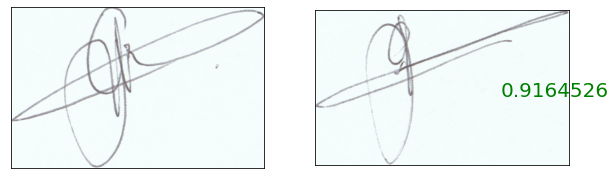

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 6))
axs[0].imshow(plt.imread(image_set[0][0]))
axs[1].imshow(plt.imread(image_set[0][1]))
axs[1].text(450, 210, cosine_similarities[0],fontsize = 20, color ="green")
for i in range(2):
  axs[i].set_xticks([]) 
  axs[i].set_yticks([]) 

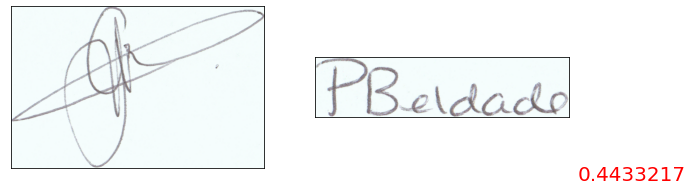

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 6))
axs[0].imshow(plt.imread(image_set1[0][0]))
axs[1].imshow(plt.imread(image_set1[0][1]))
axs[1].text(450, 210, cosine_similarities1[0],fontsize = 20, color ="red")
for i in range(2):
  axs[i].set_xticks([]) 
  axs[i].set_yticks([]) 